In [1]:
import os
%pwd

'/mnt/cb03386d-9344-47b1-82f9-868fbb64b4ae/python_projects/facial_expression_detection/research'

In [2]:
os.chdir('../')
%pwd

'/mnt/cb03386d-9344-47b1-82f9-868fbb64b4ae/python_projects/facial_expression_detection'

In [12]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class ModelEvaluationConfig:
    root_dir: Path
    test_data_path: Path
    test_labels: Path
    models_path: Path
    stats: Path
    model_params: dict

In [13]:
from src.detmood.constant import *
from src.detmood.utils.main_utils import create_directories, read_yaml

class ConfigurationManager:
    def __init__(
        self,
        config_file_path = CONFIG_FILE_PATH,
        params_file_path = PARAMS_FILE_PATH,
        schema_file_path = SCHEMA_FILE_PATH
    ):
        self.config = read_yaml(config_file_path)
        self.params = read_yaml(params_file_path)
        self.schema = read_yaml(schema_file_path)
        
        create_directories([self.config.artifacts_root])
    
    def get_model_evaluation_config(self) -> ModelEvaluationConfig:
        config = self.config.model_evaluation
        params = self.params.model
        
        create_directories([config.stats])
        
        model_evaluation_config = ModelEvaluationConfig(
            root_dir=config.root_dir,
            test_data_path=config.test_data_path,
            test_labels=config.test_labels,
            models_path=config.models_path,
            stats=config.stats,
            model_params=params
        )
        
        return model_evaluation_config

In [14]:
from src.detmood.constant.dataset_preparation import CustomImageDataset
from src.detmood.utils.main_utils import save_json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.models import EfficientNet_B0_Weights
from sklearn.metrics import confusion_matrix, classification_report
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

class ModelEvaluation:
    def __init__(self, config: ModelEvaluationConfig):
        self.config = config
    
    def prepare_dataset(self):
        test_transform = transforms.Compose([
            transforms.Resize((
                self.config.model_params.img_in_size,
                self.config.model_params.img_in_size
            )),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        dataset = CustomImageDataset(
            self.config.test_labels,
            self.config.test_data_path,
            1,
            'test',
            test_transform
        )
        
        test_loader = DataLoader(
            dataset,
            batch_size=self.config.model_params.batch_size,
            shuffle=False
        )
        
        return test_loader
    
    def model_preparation(self, model_path, device):
        model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        
        model.classifier[1] = nn.Sequential(
            nn.Linear(
                in_features=1280,
                out_features=512
            ),
            nn.ReLU(),
            nn.Linear(
                in_features=512,
                out_features=self.config.model_params.num_classes
            )
        )
        
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
        model.eval()
        
        return model.to(device)
    
    def test(self):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        for _, model_name in tqdm(enumerate(os.listdir(self.config.models_path))):
            model_path = os.path.join(self.config.models_path, model_name)
            model = self.model_preparation(model_path, device)
            
            test_loader = self.prepare_dataset()
            
            all_preds = []
            all_labels = []
            
            with torch.no_grad():
                for _, (images, labels) in tqdm(enumerate(test_loader)):
                    images = images.to(device)
                    labels = labels.to(device)
                
                    outputs = model(images)
                    _, preds = torch.max(outputs, 1)
                    
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
            report = classification_report(
                all_labels,
                all_preds,
                target_names=[f'{mood}' for mood in MOOD_DICT.keys()],
                output_dict=True
            )
            
            save_json(
                path=os.path.join(
                    self.config.stats,
                    f"{str.split(model_name, '.')[0]}_report.json"
                ),
                data=report
            )
            
            cm = confusion_matrix(all_labels, all_preds)
            plt.figure(figsize=(10, 8))
            sns.heatmap(
                cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=list(MOOD_DICT.keys()),
                yticklabels=list(MOOD_DICT.keys())
            )
            plt.xlabel('Predicted Labels')
            plt.ylabel('True Labels')
            plt.title(f"Confusion Matrix for {str.split(model_name, '.')[0]}")
            plt.savefig(os.path.join(
                self.config.stats,
                f"cm_{str.split(model_name, '.')[0]}.png"
            ))

[2024-11-29 15:43:16,145: INFO: main_utils: created directory at: artifacts]
[2024-11-29 15:43:16,147: INFO: main_utils: created directory at: artifacts/model_evaluation/stats]


0it [00:00, ?it/s]/tmp/ipykernel_20435/596050821.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device(

[2024-11-29 15:43:28,915: INFO: main_utils: json file saved at: artifacts/model_evaluation/stats/efficientnet_fold_5_report.json]



1it [00:13, 13.05s/it]/tmp/ipykernel_20435/596050821.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.de

KeyboardInterrupt: 

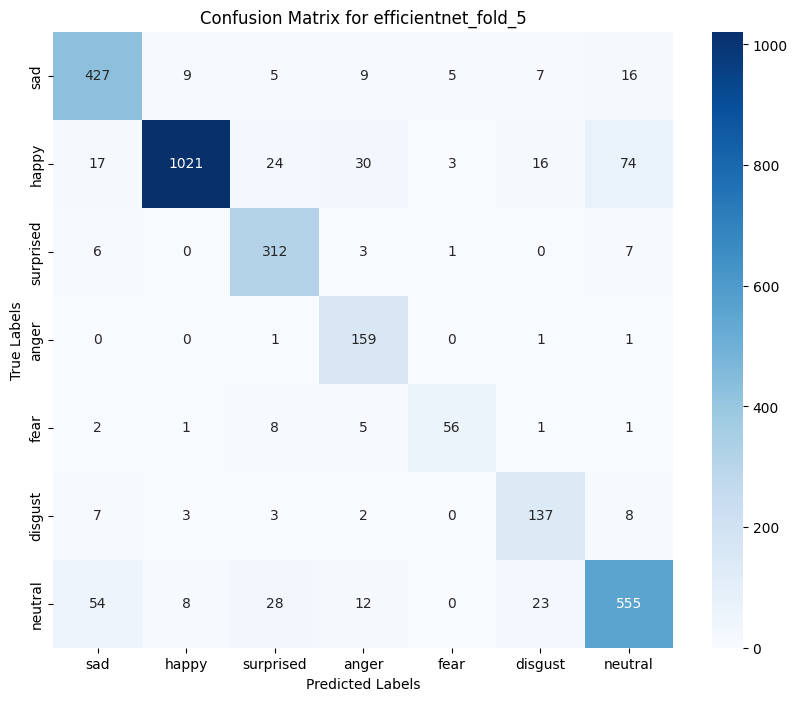

In [15]:
try:
    config = ConfigurationManager()
    model_evaluation_config = config.get_model_evaluation_config()
    model_evaluation = ModelEvaluation(config=model_evaluation_config)
    model_evaluation.test()

except Exception as e:
    raise e